# Advanced Units Implementation- Bayesian Optimization

From the advanced units I was very interested in Bayesian Optimization. This is a way to use random selection in a search space that is refined by probabilistic methods to find optimal hyperparamaters. This process can save time in tuning hyperparamaters which is very effective. I chose to replace my gridsearchCV with a Bayesian Optimization package- 'bayes-opt'

This gave me the ability to test within a search space vs. specific values as defined by a param_grid in gridsearchCV.
Using this method can save so much valuable time in figuring out what is optimal for your model.

My results ended up being similar to using GridSearchCV but much more time efficient.

In [2]:
! pip install bayesian-optimization

  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)


In [3]:
#standard imports
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

#tensorflow imports for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import layers
from keras.constraints import maxnorm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



#sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

#copy for recursive
from copy import deepcopy

from bayes_opt import BayesianOptimization

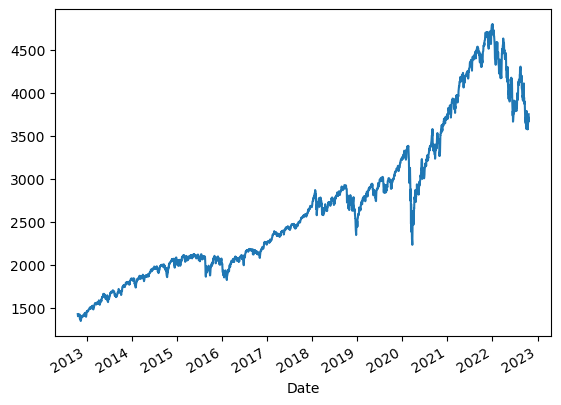

In [8]:
#read data in
df = pd.read_csv('sp500_index.csv')

#function to change string dates to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

#apply str_to_datetime
df['Date'] = df['Date'].apply(str_to_datetime)

#set index
df.set_index('Date', inplace=True)

#plot whole dataset
df['S&P500'].plot()
plt.show()

#minmax scaler
scaler=MinMaxScaler(feature_range=(0,1))
scaledclose=scaler.fit_transform(np.array(df).reshape(-1,1))
df['Close'] = scaledclose
df_new = df[['Close']]

In [41]:
#Creating windowed dataframes
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)

    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

#plotting train, val, and test data
def plot_train_val_test(dates, X, y):
    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    plt.plot(dates_train, y_train)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, y_test)

    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()
    return dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test

# Updated bayesian_optimization function
def bayesian_optimization(X_train, y_train, X_val, y_val):
    def define_model(learning_rate, neurons, dropout_rate, activation):
        activation_mapping = {0: 'relu', 1: 'sigmoid'}
        activation = activation_mapping[int(activation)]
        
        model = Sequential([
            layers.Input((X_train.shape[1], 1)),
            layers.LSTM(neurons),
            layers.Dense(32, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(32, activation=activation),
            layers.Dense(1)
        ])

        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=learning_rate),
                      metrics=['mean_absolute_error'])

        return model

    # Define the parameter search space
    params = {
        'learning_rate': (0.001, 0.15),
        'neurons': (32, 64),
        'dropout_rate': (0.1, 0.4),
        'activation': (0, 1),
        
    }

    # Define the objective function to be maximized
    def objective(learning_rate, neurons, dropout_rate, activation):
        model = define_model(learning_rate, int(neurons), dropout_rate, activation)
        model.fit(X_train, y_train, epochs=100, verbose=0)
        val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
        return -val_loss  # Negative sign because BayesianOptimization minimizes the objective

    # Perform Bayesian optimization
    optimizer = BayesianOptimization(
        f=objective,
        pbounds=params,
        random_state=1,
        verbose=0
    )
    optimizer.maximize(init_points=25, n_iter=25)

    best_params = optimizer.max['params']
    learning_rate = best_params['learning_rate']
    neurons = int(best_params['neurons'])
    dropout_rate = best_params['dropout_rate']
    activation = int(best_params['activation'])  # Cast activation to int
    activation_mapping = {0: 'relu', 1: 'sigmoid'}
    activation = activation_mapping[int(activation)]
    return learning_rate, neurons, dropout_rate, activation


#Training model on best params
def train_model(X_train, y_train, X_val, y_val, dates_val, X_test, y_test, dates_test, learning_rate, neurons, activation, dropout_rate):
    model = Sequential([layers.Input((X_train.shape[1], 1)),
                        layers.LSTM(neurons),
                        layers.Dense(32, activation=activation),
                        layers.Dropout(dropout_rate),
                        layers.Dense(32, activation=activation),
                        layers.Dense(1)])
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)
    
    recursive_predictions = []
    recursive_dates = np.concatenate([dates_val, dates_test])
    last_window = deepcopy(X_train[-1])
    for target_date in recursive_dates:
        next_prediction = model.predict(np.array([last_window])).flatten()
        recursive_predictions.append(next_prediction)
        for i in range(len(last_window)):
            if i == (len(last_window)-1):
                last_window[i] = next_prediction
            else:
                last_window[i] = last_window[i+1]
    return train_predictions, val_predictions, test_predictions, recursive_predictions

#function to plot various graphs
def plot_prediction_graphs(dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test, train_predictions, val_predictions, test_predictions, recursive_predictions):
    y_train = y_train.reshape(-1, 1)
    train_predictions=scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.legend(['Training Predictions', 'Training Observations'])
    plt.show()

    y_val = y_val.reshape(-1, 1)
    val_predictions=scaler.inverse_transform(val_predictions)
    y_val = scaler.inverse_transform(y_val)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.show()

    y_test = y_test.reshape(-1, 1)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Testing Predictions', 'Testing Observations'])
    plt.show()

    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])
    plt.show()
    
    recursive_dates = np.concatenate([dates_val, dates_test])
    recursive_predictions = scaler.inverse_transform(recursive_predictions)
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.plot(recursive_dates, recursive_predictions)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations',
                'Recursive Predictions'])
    plt.show()
    
    recursive_test = np.concatenate((np.array(y_val), np.array(y_test)))
   
    print(f"Mean Absolute Error for Training Data is: {mean_absolute_error(y_train, train_predictions)}")
    print(f"Mean Absolute Error for Validation Data is: {mean_absolute_error(y_val, val_predictions)}")
    print(f"Mean Absolute Error for Test Data is: {mean_absolute_error(y_test, test_predictions)}")
    print(f"Mean Absolute Error for Recursive Data is: {mean_absolute_error(recursive_test, recursive_predictions)}")

#function to run the whole script
def mle_analysis(df):
    windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=5)
    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = plot_train_val_test(dates, X, y)
    learning_rate, neurons, dropout_rate, activation = bayesian_optimization(X_train, y_train, X_val, y_val)
    train_predictions, val_predictions, test_predictions, recursive_predictions = train_model(X_train, y_train, X_val, y_val, dates_val, X_test, y_test, dates_test, learning_rate, neurons, activation, dropout_rate)
    plot_prediction_graphs(dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test, train_predictions, val_predictions, test_predictions, recursive_predictions)


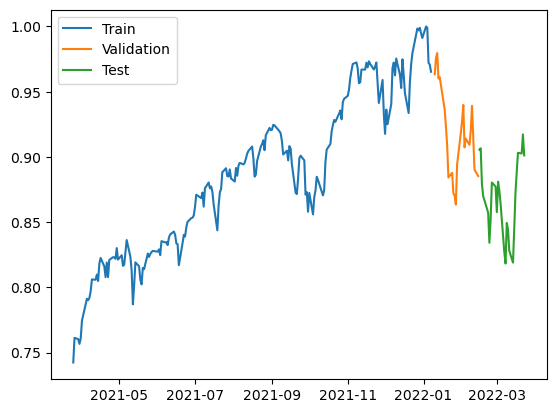

Epoch 1/100
7/7 [==============================] - 2s 72ms/step - loss: 0.8203 - mean_absolute_error: 0.7191 - val_loss: 0.2681 - val_mean_absolute_error: 0.5170
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1045 - mean_absolute_error: 0.2802 - val_loss: 0.0452 - val_mean_absolute_error: 0.2109
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0272 - mean_absolute_error: 0.1268 - val_loss: 0.0053 - val_mean_absolute_error: 0.0677
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0149 - mean_absolute_error: 0.1049 - val_loss: 0.0139 - val_mean_absolute_error: 0.1143
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0094 - mean_absolute_error: 0.0729 - val_loss: 8.4438e-04 - val_mean_absolute_error: 0.0237
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0092 - mean_absolute_error: 0.0784 - val_loss: 0.0043 - val_mean_absolute_error: 0.0586
Epoch 7/100
7/7 [=========

7/7 [==============================] - 0s 12ms/step - loss: 5.7290e-04 - mean_absolute_error: 0.0191 - val_loss: 6.5633e-04 - val_mean_absolute_error: 0.0201
Epoch 51/100
7/7 [==============================] - 0s 12ms/step - loss: 6.0553e-04 - mean_absolute_error: 0.0178 - val_loss: 8.1765e-04 - val_mean_absolute_error: 0.0248
Epoch 52/100
7/7 [==============================] - 0s 17ms/step - loss: 5.5060e-04 - mean_absolute_error: 0.0188 - val_loss: 9.1226e-04 - val_mean_absolute_error: 0.0260
Epoch 53/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0010 - mean_absolute_error: 0.0263 - val_loss: 5.3924e-04 - val_mean_absolute_error: 0.0193
Epoch 54/100
7/7 [==============================] - 0s 10ms/step - loss: 8.6894e-04 - mean_absolute_error: 0.0234 - val_loss: 5.7984e-04 - val_mean_absolute_error: 0.0194
Epoch 55/100
7/7 [==============================] - 0s 10ms/step - loss: 9.3701e-04 - mean_absolute_error: 0.0264 - val_loss: 5.1111e-04 - val_mean_absolute_error

7/7 [==============================] - 0s 11ms/step - loss: 4.7835e-04 - mean_absolute_error: 0.0178 - val_loss: 5.4435e-04 - val_mean_absolute_error: 0.0192
Epoch 99/100
7/7 [==============================] - 0s 10ms/step - loss: 4.3226e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0014 - val_mean_absolute_error: 0.0319
Epoch 100/100
1/1 [==============================] - 0s 14ms/step


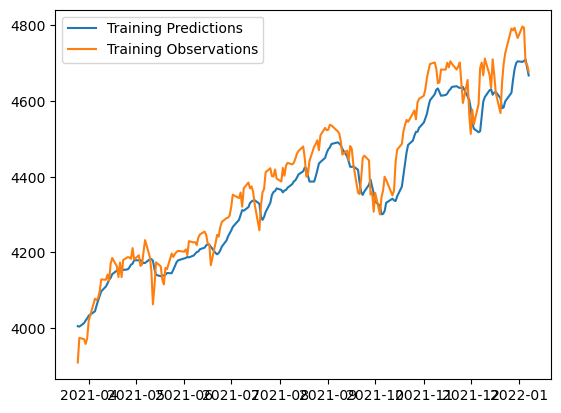

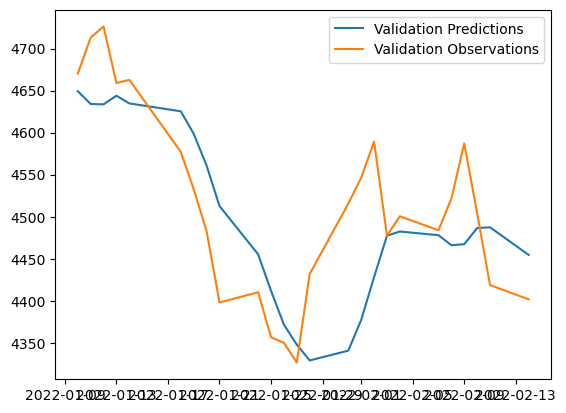

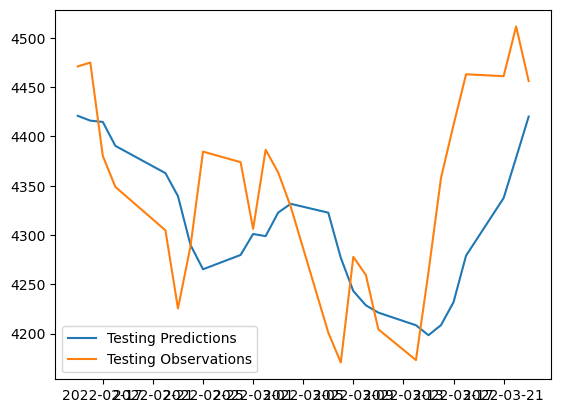

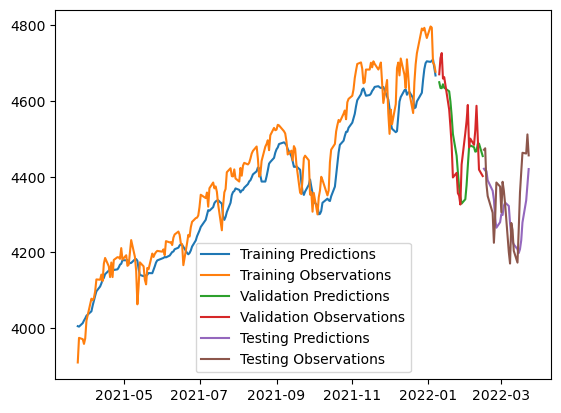

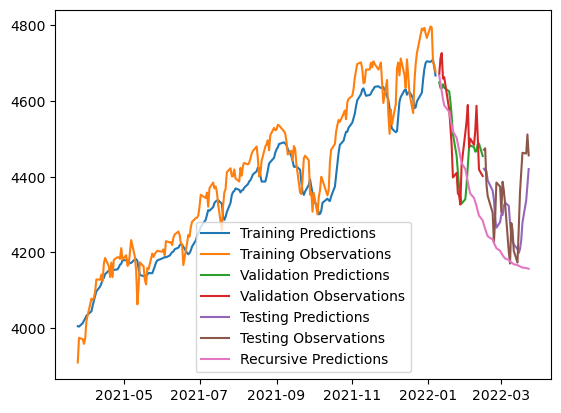

Mean Absolute Error for Training Data is: 49.657806396484375
Mean Absolute Error for Validation Data is: 65.32986450195312
Mean Absolute Error for Test Data is: 73.99442291259766
Mean Absolute Error for Recursive Data is: 127.63734876587114


In [42]:
mle_analysis(df_new)